In [1]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')

if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [2]:
from __future__ import print_function, division

from collections import Counter, OrderedDict

import hosts
import targeting
import mmthecto
import numpy as np

from astropy import units as u
from astropy.coordinates import *
from astropy import table
from astropy.visualization import hist as ahist

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib import patches

rcParams['image.interpolation'] = 'none'
rcParams['figure.figsize'] = (16, 10)
plt.rcParams['image.cmap'] = 'viridis'

In [19]:
DATESUFFIX = 'oct2016'

In [104]:
proposed_targets = [126115, 150578, 135879, 132339, 129237, 161174]

# Choose hosts and Load stuff

In [105]:
hostlst = hosts.get_saga_hosts_from_google() #'named' hosts

Using cached version of google hosts list from file "hosts_dl.pkl2"


In [106]:
hosts_to_target = []
for nsanum in proposed_targets:
    for h in hostlst:
        if h.nsaid == nsanum:
            hosts_to_target.append(h)
            break
    else:
        # new target
        hosts_to_target.append(hosts.NSAHost(nsanum))
hosts_to_target

[<hosts.NSAHost object w/ name 'Bandamanna' AKA: ['NGC7818', 'NSA126115']>,
 <hosts.NSAHost object w/ name 'NSA150578'>,
 <hosts.NSAHost object w/ name 'NSA135879'>,
 <hosts.NSAHost object w/ name 'Narnia' AKA: ['NGC1015', 'NSA132339']>,
 <hosts.NSAHost object w/ name 'NSA129237'>,
 <hosts.NSAHost object w/ name 'NSA161174'>]

In [107]:
# now set to the latest base catalogs
for h in hosts_to_target:
    h.fnsdss = 'SAGADropbox/base_catalogs/base_sql_nsa{0}.fits.gz'.format(h.nsaid)
    h._cached_sdss = None

In [108]:
# actually make sure they're loaded
torem = []
for h in hosts_to_target:
    try:
        h.get_sdss_catalog()
    except IOError:
        torem.append(h)
        print('Failed to load base catalog for', h, 'so removing from hosts_to_target')
        
hosts_to_target_orig = hosts_to_target[:]
for h in torem:
    hosts_to_target.remove(h)

In [109]:
# preview the catalog
hosts_to_target[0].get_sdss_catalog()

OBJID,RA,DEC,PHOTPTYPE,PHOT_SG,FLAGS,clean,SATURATED,BAD_COUNTS_ERROR,BINNED1,TOO_FEW_GOOD_DETECTIONS,u,g,r,i,z,u_err,g_err,r_err,i_err,z_err,MODELMAGERR_U,MODELMAGERR_G,MODELMAGERR_R,MODELMAGERR_I,MODELMAGERR_Z,EXTINCTION_U,EXTINCTION_G,EXTINCTION_R,EXTINCTION_I,EXTINCTION_Z,DERED_U,DERED_G,DERED_R,DERED_I,DERED_Z,PETRORAD_U,PETRORAD_G,PETRORAD_R,PETRORAD_I,PETRORAD_Z,PETRORADERR_U,PETRORADERR_G,PETRORADERR_R,PETRORADERR_I,PETRORADERR_Z,DEVRAD_U,DEVRADERR_U,DEVRAD_G,DEVRADERR_G,DEVRAD_R,DEVRADERR_R,DEVRAD_I,DEVRADERR_I,DEVRAD_Z,DEVRADERR_Z,DEVAB_U,DEVAB_G,DEVAB_R,DEVAB_I,DEVAB_Z,CMODELMAG_U,CMODELMAGERR_U,CMODELMAG_G,CMODELMAGERR_G,CMODELMAG_R,CMODELMAGERR_R,CMODELMAG_I,CMODELMAGERR_I,CMODELMAG_Z,CMODELMAGERR_Z,PSFMAG_U,PSFMAGERR_U,PSFMAG_G,PSFMAGERR_G,PSFMAG_R,PSFMAGERR_R,PSFMAG_I,PSFMAGERR_I,PSFMAG_Z,PSFMAGERR_Z,FIBERMAG_U,FIBERMAGERR_U,FIBERMAG_G,FIBERMAGERR_G,FIBERMAG_R,FIBERMAGERR_R,FIBERMAG_I,FIBERMAGERR_I,FIBERMAG_Z,FIBERMAGERR_Z,FRACDEV_U,FRACDEV_G,FRACDEV_R,FRACDEV_I,FRACDEV_Z,Q_U,U_U,Q_G,U_G,Q_R,U_R,Q_I,U_I,Q_Z,U_Z,EXPAB_U,EXPRAD_U,EXPPHI_U,EXPAB_G,EXPRAD_G,EXPPHI_G,EXPAB_R,EXPRAD_R,EXPPHI_R,EXPAB_I,EXPRAD_I,EXPPHI_I,EXPAB_Z,EXPRAD_Z,EXPPHI_Z,FIBER2MAG_R,FIBER2MAGERR_R,EXPMAG_R,EXPMAGERR_R,PETROR50_R,PETROR90_R,PETROMAG_R,SB_EXP_R,SB_PETRO_R,J,JERR,H,HERR,K,KERR,SPEC_Z,SPEC_Z_ERR,SPEC_Z_WARN,PHOTOZ,PHOTOZ_ERR,W1,W1ERR,W2,W2ERR,HOST_RA,HOST_DEC,HOST_DIST,HOST_VHOST,HOST_MK,HOST_MR,HOST_MG,HOST_NSAID,HOST_SAGA_NAME,RHOST_ARCM,RHOST_KPC,OBJ_NSAID,SATS,PROBABILITY_CLASS1,RESCALED_PROBABILITY_CLASS1,REMOVE,TELNAME,MASKNAME,ZQUALITY,SPEC_CLASS,SPECOBJID,SPEC_REPEAT,Ai,fibermag_z,rhost,fibermag_r,fibermag_u,Ag,fibermag_i,Az,Ar,dec,Au,fibermag_g,type,ra,objID,psf_r,psf_u,psf_z,rhost_kpc,phot_sg,psf_g,psf_i,U,B,V,R,I,psf_U,psf_B,psf_V,psf_R,psf_I
int64,float64,float64,int16,str40,int64,int32,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str48,float64,float64,int64,int64,float64,float64,int64,str6,str48,int64,str2,str48,str48,float32,float32,float64,float32,float32,float32,float32,float32,float32,float64,float32,float32,int16,float64,int64,float32,float32,float32,float64,str40,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
1237680247351672957,0.995575122267,20.7524099889,3,GALAXY,105656498651152,1,0,0,268435456,0,14.2853,12.8044,11.9377,11.4279,11.0222,0.00949019,0.000935407,0.000573401,0.000569579,0.00146553,0.258206,0.0426484,0.024065,0.0183603,0.0302881,0.299514,0.22038,0.159838,0.1212,0.0859324,21.4993,20.4597,19.3215,18.5531,17.9055,1.32235,1.34169,1.37461,1.43516,1.49363,0.353329,0.104188,0.0561147,0.0433549,0.0759478,0.00412682,22.6817,0.0101819,2.49969,0.159861,0.0392906,0.240542,0.0350321,0.262777,0.0802993,0.110489,0.0803386,0.999782,0.999706,0.995768,21.8616,0.911032,20.7695,0.0632721,19.4814,0.0246741,18.5847,0.0182752,17.8988,0.0326979,21.8349,0.326354,20.7707,0.138882,19.6115

In [110]:
# these are the already-observed objects
spectra = h.load_and_reprocess_sdss_catalog('SAGADropbox/data/saga_spectra_clean_jan15.fits.gz')

# Ranking 

rank | desc
--- | ---
1 | Flux Stars
2 | Special targets
3 | r<300 kpc, ugri cuts, M_r<20
4 | r<300 kpc, ugri cuts, M_r<20.75
5 | r<300 kpc, gri cuts, M_r<20.75
6 | 300<r<450 kpc, ugri cuts, M_r<20.75
7 | 300<r<450 kpc, gri cuts, M_r<20.75
8 | other

The ugr cut is:  $ u-g > 1.5(g-r) - 0.25$
(that's the *cut*, not the accept condition)

## Fix up wrong-distance hosts if need be

In [111]:
for h in hosts_to_target:
    fix = False
    cat = h.get_sdss_catalog()
    if np.median(cat['RHOST_KPC']) > 600:
        print('RHOST distances wrong for', h)
        fix = 1
    if np.abs(np.median(cat['HOST_DIST'])-h.distmpc)/h.distmpc > 0.05:
        print('HOST_DIST wrong on', h)
        fix = 2
        
    if fix:
        scs = SkyCoord(cat['RA'], cat['DEC'], unit=u.deg)
        cat['RHOST_ARCM'] = scs.separation(h.coords).to(u.arcmin).value
        cat['RHOST_KPC'] = scs.separation(h.coords).to(u.radian).value * h.distmpc*1000

In [112]:
def rank_targets(cat, ugoffset=-0.25):
    corrmag = {band: cat[band] - cat['A'+band]  for band in 'ugri'}
    
    phot_good = (cat['r']<21.25)& (cat['fibermag_r']<23)&(cat['phot_sg']=='GALAXY')
    
    gmr_wunc = corrmag['g']- corrmag['r'] - 2*np.hypot(cat['g_err'], cat['r_err'])
    rmi_wunc = corrmag['r']- corrmag['i'] - 2*np.hypot(cat['g_err'], cat['r_err'])
    
    gmr_accept = gmr_wunc < 0.85
    rmi_accept = rmi_wunc < 0.55
    if ugoffset is None:
        # this is a *cut*, meaning True means get rid of it
        ug_cut = np.zeros_like(gmr_accept)
    else:
        ug_cut = corrmag['u'] - corrmag['g'] < (1.5*(corrmag['g'] - corrmag['r']) + ugoffset)
    
    gri_accept  = gmr_accept&gmr_accept
    ugri_accept  = gri_accept&~ug_cut
    
    r_bright = corrmag['r'] < 20.
    r_ok = corrmag['r'] < 20.75
    r_faint = r_ok&~r_bright
    
    near = cat['RHOST_KPC']<300
    nearish = (cat['RHOST_KPC']<450) & ~near
    
    ranks = np.zeros(len(cat), dtype=int)
    
    
    ranks[r_ok & gri_accept & nearish & phot_good] = 7
    ranks[r_ok & ugri_accept & nearish & phot_good] = 6
    ranks[r_ok & gri_accept & near & phot_good] = 5
    ranks[r_ok & ugri_accept & near & phot_good] = 4
    ranks[r_bright & ugri_accept & near & phot_good] = 3
    
    ranks[(ranks==0)&phot_good] = 8  # other
    
    do_checks(cat, ranks)
    
    return ranks

def do_checks(cat, ranks):
    
    zq = cat['ZQUALITY'].copy()
    # ranks ~-100 are removed due to already-observed
    havespec = zq>=3
    ranks[havespec] = -100 - zq[havespec]
    
    # this *shouldn't* be necessary, as ZQUALITY should be in the base catalog.  
    # But as a sanity check we look to see if anything in the spectral catalog is still being included
    spec_this_host = spectra[spectra['HOST_NSAID']==h.nsaid]
    spec_this_host = spec_this_host[np.in1d(spec_this_host['OBJID'], cat['OBJID'])]

    for i, zqi in zip(spec_this_host['OBJID'], spec_this_host['ZQUALITY']):
        zq[cat['OBJID']==i] = zqi
    if np.any(ranks[zq>2]>=0):
        print('POSSIBLE PROBLEM: Found some objects in spectrum list that are *not* claimed ' 
              'as having spectra in the base catalogs.  Setting them to -11x:', dict(Counter(ranks[ranks<-110])))
        ranks[zq>2] = -110 - zq[zq>2]
    
    # remove list
    tokeep = cat['REMOVE']==-1
    ranks[~tokeep] = -cat['REMOVE'][~tokeep] # sets the REMOVE objects to -their remove value
    remmskval =  np.min(ranks)-1
    # remove anything in the remove list online but not in the catalog as remove
    ranks[~targeting.remove_targets_with_remlist(cat, h, maskonly=True, verbose='warning')&(ranks>-1)] = remmskval
    if np.sum(ranks==remmskval) > 0:
        print('Removed', np.sum(ranks==remmskval), 'due to online remove list. Remmsk val:', remmskval)
    
    #de-duplicate
    if len(np.unique(cat['OBJID'])) != len(cat):
        _, idxs = np.unique(cat['OBJID'], return_index=True)
        msk = np.ones_like(cat, dtype=bool)
        msk[idxs] = 0
        ranks[msk] = -1000
        
        print('WARNING: some duplicate objid found.  Setting', np.sum(ranks==-1000), 'dupes to pri=-1000')


In [113]:
for h in hosts_to_target:
    print('On host', h.name)
    cat = h.get_sdss_catalog()

    cat['mmt_ranks'] = rank_targets(cat)
    print(Counter(cat['mmt_ranks']), end='\n\n')

On host Bandamanna
Counter({0: 38678, -3: 12218, 8: 8821, 6: 867, -104: 533, 7: 517, 5: 359, 4: 334, 3: 305, -2: 81, -4: 47, -1: 31, -1000: 8})

On host NSA150578
Counter({0: 41519, -3: 12360, 8: 7840, 6: 1115, -104: 749, 7: 701, 5: 532, 4: 488, 3: 440, -2: 92, -4: 63, -1: 9, -1000: 8})

On host NSA135879
No matches found for host "NSA135879" in remove list. Maybe you mis-typed something?
Counter({0: 51442, -3: 12350, 8: 8281, 6: 1118, -104: 760, -2: 606, 7: 588, 4: 454, 5: 454, 3: 427, -4: 75, -1000: 7, -1: 1})

On host Narnia
POSSIBLE PROBLEM: Found some objects in spectrum list that are *not* claimed as having spectra in the base catalogs.  Setting them to -11x: {}
Counter({0: 51489, -3: 14316, 8: 11040, -114: 2536, 6: 742, -2: 430, 7: 340, -113: 201, -4: 189, 4: 87, 5: 73, 3: 19, -1: 14, -1000: 12})

On host NSA129237
POSSIBLE PROBLEM: Found some objects in spectrum list that are *not* claimed as having spectra in the base catalogs.  Setting them to -11x: {}
Counter({0: 40954, -3: 

# Plot catalogs w/ ranks 

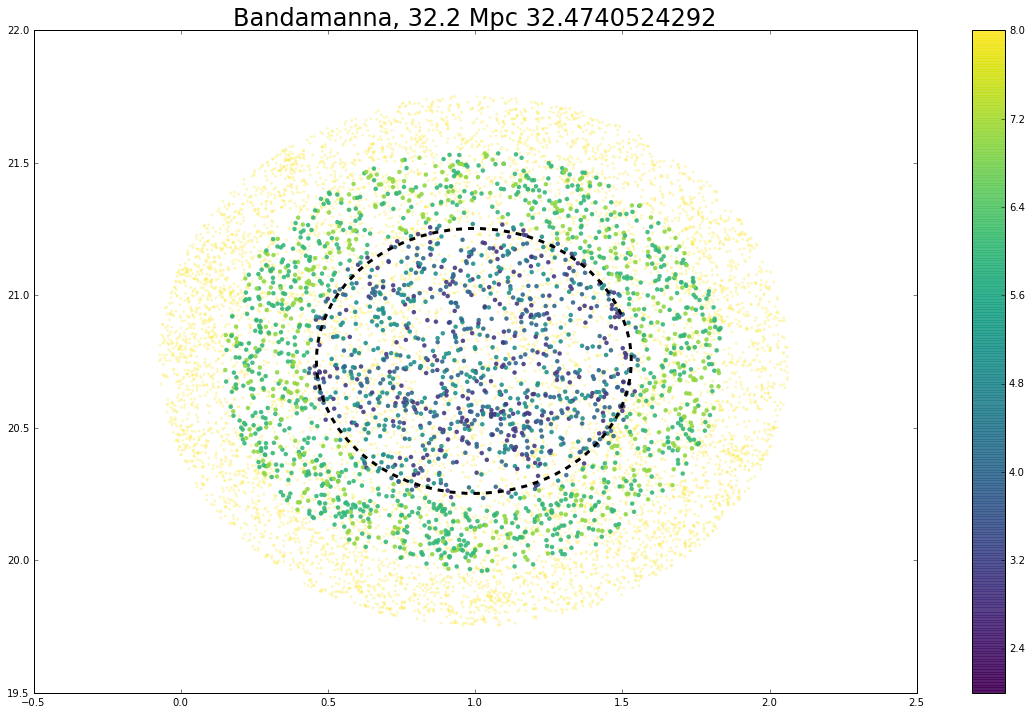

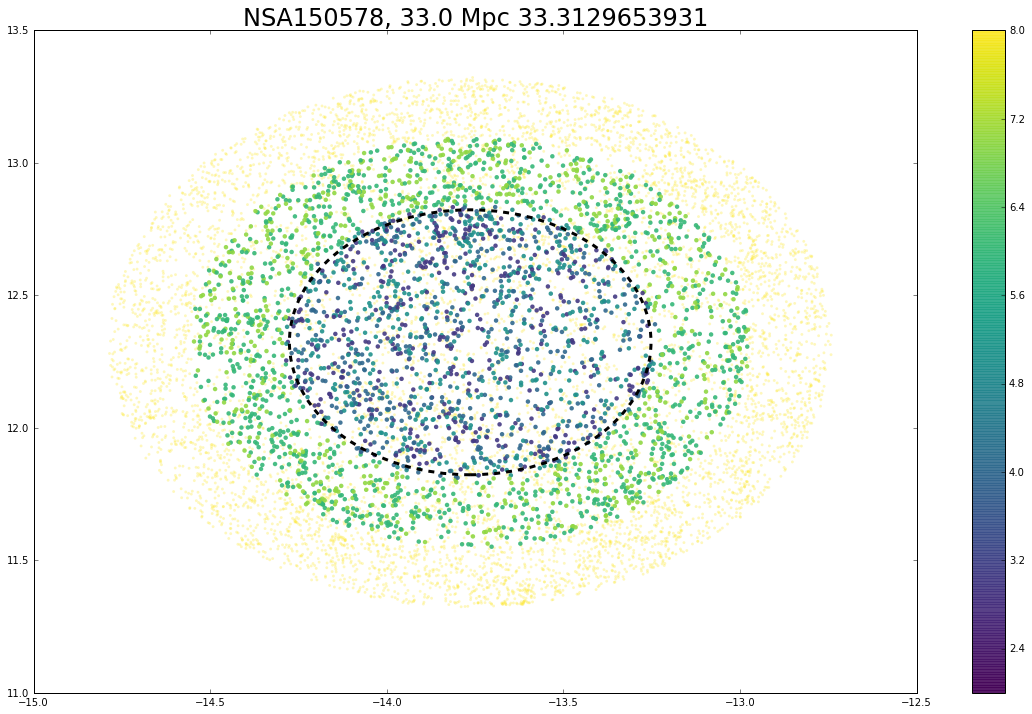

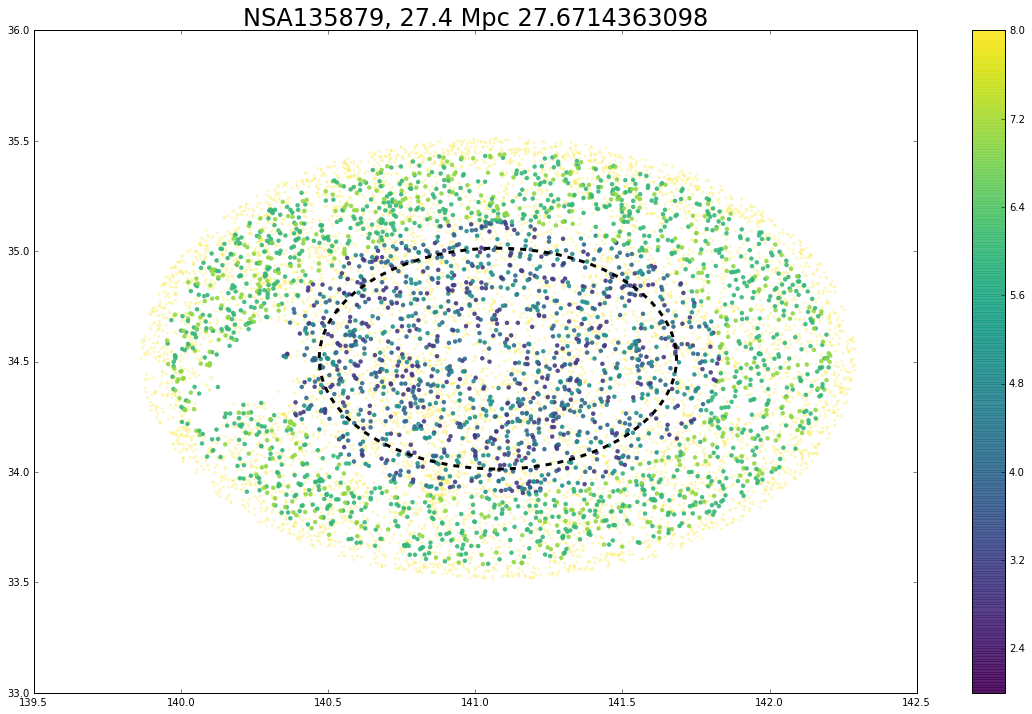

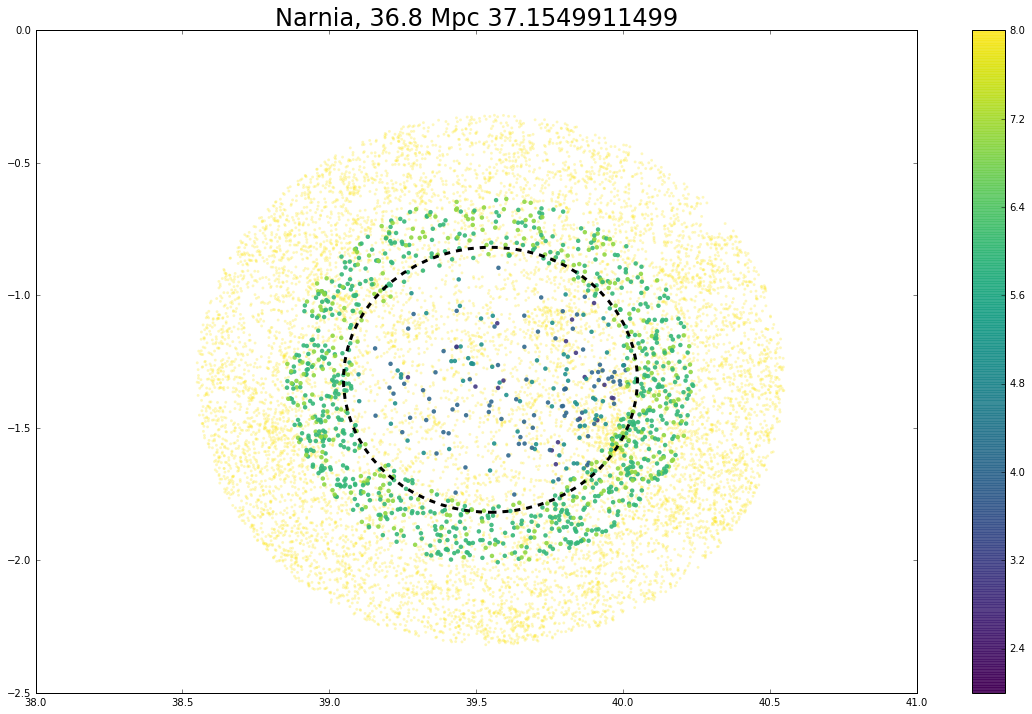

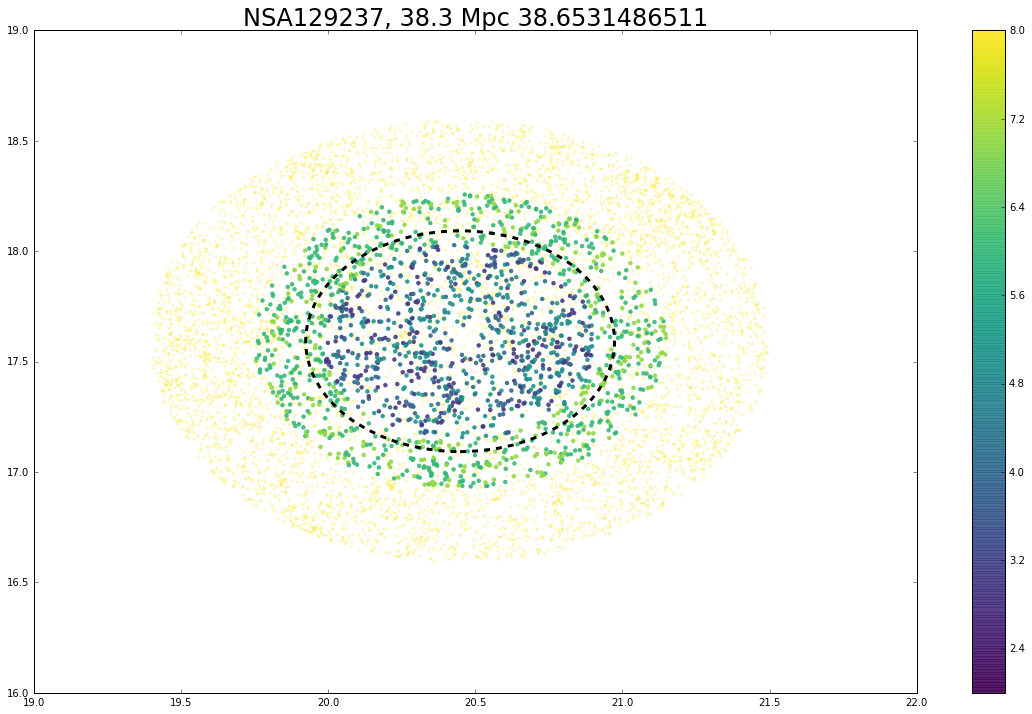

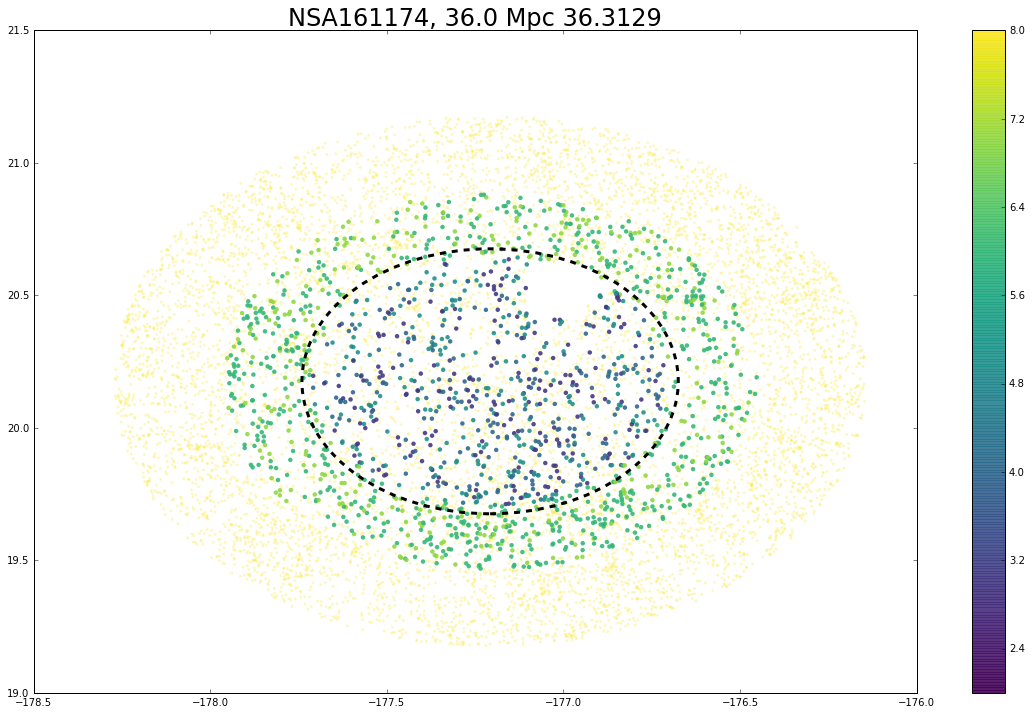

In [114]:
for h in hosts_to_target:
    cat = h.get_sdss_catalog()
    ranks = cat['mmt_ranks']

    plt.figure()
    
    msk_good = (ranks>1)&(ranks<8)
    msk_bad = (ranks>7)
    
    ras = Angle(cat['ra'], u.deg).wrap_at(180*u.deg)
    decs = cat['dec']
    
    plt.scatter(ras[msk_bad], decs[msk_bad], 
                lw=0, alpha=.3, c=ranks[msk_bad],s=8, vmin=2, vmax=np.max(ranks))
    plt.scatter(ras[msk_good], decs[msk_good], 
                lw=0, alpha=.9, c=ranks[msk_good],s=20, vmin=2, vmax=np.max(ranks))
    
    plt.colorbar()
    
    ell = patches.Ellipse((Angle(h.ra, u.deg).wrap_at(180*u.deg).value, h.dec),
                          1./np.cos(np.radians(h.dec)), 1,
                         fc='none', ec='k', lw=3, ls='--')
    plt.gca().add_patch(ell)
    
    
    plt.title('{}, {:.1f} {}'.format(h.name, h.dist, np.unique(cat['HOST_DIST'])[0]), fontsize=24)
    
    plt.tight_layout()

In [115]:
needmorefluxstars = [129237, 150578]

generated_cats = {}
for h in hosts_to_target:
    if generated_cats:
        print('') # makes a newline except for on the first one
    print('On host', h.name)
    sys.stdout.flush()

    cat = h.get_sdss_catalog()
    ranks = cat['mmt_ranks']
    
    fnout = 'mmthecto/{0}_{1}.cat'.format(h.name, DATESUFFIX)
    fluxfnout = fnout.replace('.cat', '.fluxstars')
    print('Going to write', fnout)
    
    msk = (cat['RHOST_ARCM']<40) & (ranks>0) & (ranks<8)
    
    if h.nsaid in needmorefluxstars:
        fluxrng = (17., 18.)
        removefluxdistance = (20*u.arcsec, ranks[msk]<6)
    else:
        fluxrng = (17., 17.7)
        removefluxdistance = (40*u.arcsec, ranks[msk]<6)
    
    generated_cats[h] = mmthecto.generate_catalog(h, cat[msk], ranks[msk],
                                                  fnout=fnout, fluxfnout=fluxfnout,
                                                  repeatflux=4, fluxrng=fluxrng,
                                                  removefluxdistance=removefluxdistance)

On host Bandamanna
Going to write mmthecto/Bandamanna_oct2016.cat
Including 1620 targets
Found 86 Flux stars
Removing 12 Flux stars too close to program stars
Final flux star count: 74 and 10 are in 1 deg FOV
Found 447 guide stars

On host NSA150578
Going to write mmthecto/NSA150578_oct2016.cat
Including 2420 targets
Found 88 Flux stars
Removing 7 Flux stars too close to program stars
Final flux star count: 81 and 19 are in 1 deg FOV
Found 413 guide stars

On host NSA135879
Going to write mmthecto/NSA135879_oct2016.cat
Including 1520 targets
Found 57 Flux stars
Removing 4 Flux stars too close to program stars
Final flux star count: 53 and 13 are in 1 deg FOV
Found 336 guide stars

On host Narnia
Going to write mmthecto/Narnia_oct2016.cat
Including 1100 targets
Found 46 Flux stars
Removing 1 Flux stars too close to program stars
Final flux star count: 45 and 13 are in 1 deg FOV
Found 270 guide stars

On host NSA129237
Going to write mmthecto/NSA129237_oct2016.cat
Including 1833 targets


## Inspect those that seem to be lacking in flux stars 

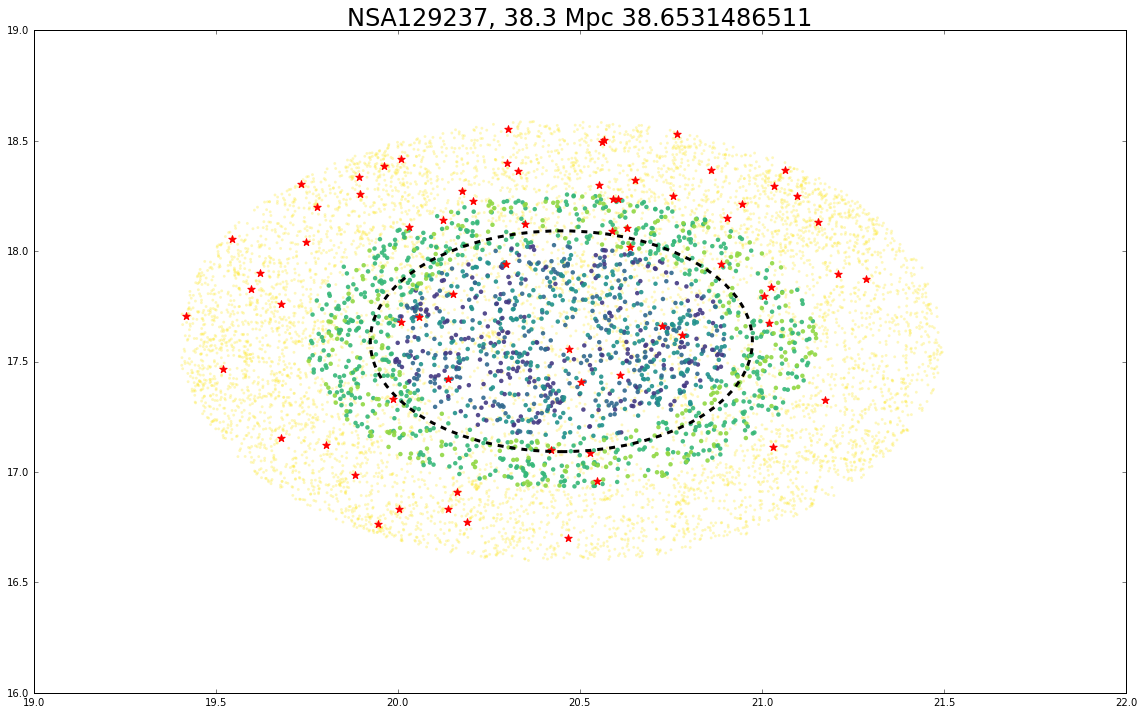

In [84]:
for h in [h for h in hosts_to_target if h.nsaid in toofewflux]:
    cat = h.get_sdss_catalog()
    gcat = generated_cats[h]
    ranks = cat['mmt_ranks']
    
    fstars = gcat[gcat['rank']=='1'][::4]

    plt.figure()
    
    msk_good = (ranks>1)&(ranks<8)
    msk_bad = (ranks>7)
    
    ras = Angle(cat['ra'], u.deg).wrap_at(180*u.deg)
    decs = cat['dec']
    
    plt.scatter(ras[msk_bad], decs[msk_bad], 
                lw=0, alpha=.3, c=ranks[msk_bad],s=8, vmin=2, vmax=np.max(ranks))
    plt.scatter(ras[msk_good], decs[msk_good], 
                lw=0, alpha=.9, c=ranks[msk_good],s=20, vmin=2, vmax=np.max(ranks))
    
    plt.scatter(fstars['ra'], fstars['dec'], color='r', s=60, marker='*')
    
    ell = patches.Ellipse((Angle(h.ra, u.deg).wrap_at(180*u.deg).value, h.dec),
                          1./np.cos(np.radians(h.dec)), 1,
                         fc='none', ec='k', lw=3, ls='--')
    plt.gca().add_patch(ell)
    
    
    plt.title('{}, {:.1f} {}'.format(h.name, h.dist, np.unique(cat['HOST_DIST'])[0]), fontsize=24)
    
    plt.tight_layout()

# Now try making xfitfibs test configs 

In [18]:
def compute_percentage(matched, targets):
    """
    Inputs should come from "By rank" table of xfitfibs, ranks 3/4/5
    """
    perc_ugri = (matched[0]+ matched[1])/(targets[0]+ targets[1])
    perc_gri = (matched[0]+ matched[1]+ matched[2])/(targets[0]+ targets[1]+ targets[2])
    
    return '{:.1%} | {:.1%}'.format(perc_ugri, perc_gri)

compute_percentage([350, 374, 60], [398,514,474])

'79.4% | 56.6%'

### NSA129237

The most distant of the new ones

nconfigs | ugri completeness | gri completeness
:---:|:---:|:---:
1 | 45.8% | 29.8% 
2 | 85.7% | 60.2% 
3 | 98.6% | 85.9%

This one covers all the rank 3/4/5 region with one config, but needs multiples to get completeness up

### NSA21709

Closest of the new ones (29.2 Mpc)

nconfigs | ugri completeness | gri completeness
:---:|:---:|:---:
1 | 26.3% | 17.7%
2 | 52.7% | 35.3%
3 | 79.4% | 56.6%

This takes 3 fields to cover the area, but even with those 3, the lower percentages here are probably still due to collisions/need to repeat an area at least once

# Inspecting ugri cuts 

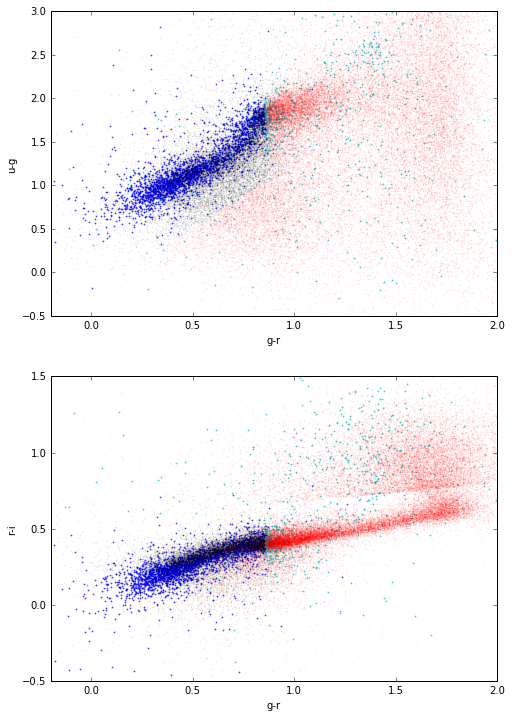

In [19]:
lowzmsk = spectra['SATS']>0
corrmag = {band: spectra[band] - spectra['A'+band]  for band in 'ugri'}


gmr_wunc = corrmag['g']- corrmag['r'] - 2*np.hypot(spectra['g_err'], spectra['r_err'])
rmi_wunc = corrmag['r']- corrmag['i'] - 2*np.hypot(spectra['g_err'], spectra['r_err'])
gmr_accept = gmr_wunc < 0.85
rmi_accept = rmi_wunc < 0.55
ug_cut = corrmag['u'] - corrmag['g'] < (1.5*(corrmag['g'] - corrmag['r']) - 0.25)
cuts = gmr_accept&rmi_accept&~ug_cut

umg = corrmag['u'] - corrmag['g']
gmr = corrmag['g'] - corrmag['r']
rmi = corrmag['r'] - corrmag['i']

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 12))

ax1.scatter(gmr[lowzmsk&cuts], umg[lowzmsk&cuts], alpha=.75, s=3, lw=0, c='b')
ax1.scatter(gmr[~lowzmsk&cuts], umg[~lowzmsk&cuts], alpha=.1, s=2, lw=0, c='k')
ax1.scatter(gmr[lowzmsk&~cuts], umg[lowzmsk&~cuts], alpha=.75, s=3, lw=0, c='c')
ax1.scatter(gmr[~lowzmsk&~cuts], umg[~lowzmsk&~cuts], alpha=.1, s=2, lw=0, c='r')

ax1.set_xlim(-0.2, 2)
ax1.set_ylim(-0.5, 3)
ax1.set_xlabel('g-r')
ax1.set_ylabel('u-g')


ax2.scatter(gmr[lowzmsk&cuts], rmi[lowzmsk&cuts], alpha=.75, s=3, lw=0, c='b')
ax2.scatter(gmr[~lowzmsk&cuts], rmi[~lowzmsk&cuts], alpha=.1, s=2, lw=0, c='k')
ax2.scatter(gmr[lowzmsk&~cuts], rmi[lowzmsk&~cuts], alpha=.75, s=3, lw=0, c='c')
ax2.scatter(gmr[~lowzmsk&~cuts], rmi[~lowzmsk&~cuts], alpha=.1, s=2, lw=0, c='r')
ax2.set_xlim(-0.2, 2)
ax2.set_ylim(-0.5, 1.5)
ax2.set_xlabel('g-r')
ax2.set_ylabel('r-i')